In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
taruntiwarihp_phishing_site_urls_path = kagglehub.dataset_download('taruntiwarihp/phishing-site-urls')

print('Data source import complete.')


Using Colab cache for faster access to the 'phishing-site-urls' dataset.
Data source import complete.


In [ ]:
# 📘 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib  # For saving model


In [ ]:
# 📂 2. Load Dataset
df = pd.read_csv("phishing_site_urls.csv")  # Replace with your actual file
df.head()


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
df.isnull().sum()

,0
URL,0
Label,0


In [ ]:
df.duplicated().sum()


np.int64(42150)

In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df.duplicated().sum()


np.int64(0)

Dataset shape: (507196, 2)
Null values:
 URL      0
Label    0
dtype: int64
Label distribution:
 Label
good    392897
bad     114299
Name: count, dtype: int64


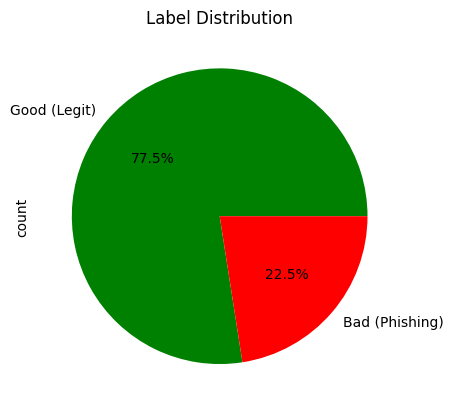

In [ ]:
# 🔍 3. Explore the Dataset
print("Dataset shape:", df.shape)
print("Null values:\n", df.isnull().sum())
print("Label distribution:\n", df['Label'].value_counts())

# Pie chart
df['Label'].value_counts().plot.pie(autopct="%1.1f%%", labels=["Good (Legit)", "Bad (Phishing)"], colors=["green", "red"])
plt.title("Label Distribution")
plt.show()


In [ ]:
# 🧹 4. Preprocessing
# Encode labels: Good → 1 (Legit), Bad → 0 (Phishing)
df['Label'] = df['Label'].map({'good': 1, 'bad': 0})
print("\nEncoded Labels:\n", df['Label'].value_counts())



Encoded Labels:
 Label
1    392897
0    114299
Name: count, dtype: int64


In [ ]:
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0
...,...,...
516466,23.227.196.215/,0
516467,apple-checker.org/,0
516468,apple-iclods.org/,0
516469,apple-uptoday.org/,0


In [ ]:
# ✂️ Updated Preprocessing with Stemming
import re
from nltk.stem import SnowballStemmer

# Initialize the stemmer (English language)
stemmer = SnowballStemmer("english")

def clean_url(url):
    # 1. Basic Cleaning (Same as before)
    url = url.lower()
    url = re.sub(r'https?:\/\/', '', url)
    url = re.sub(r'www\d*\.', '', url)
    url = re.sub(r'[^a-z0-9\-\.\/]', ' ', url)
    url = re.sub(r'\s+', ' ', url)

    # 2. Stemming (The New Part!)
    # Split the sentence into words, chop them, and join them back
    words = url.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    return " ".join(stemmed_words)

# Apply this new function to your data
print("Applying Stemming... this might take a minute...")
df['clean_url'] = df['URL'].apply(clean_url)
print("Done! Here is the new cleaned data:")
print(df[['URL', 'clean_url']].head())

Applying Stemming... this might take a minute...
Done! Here is the new cleaned data:
                                                 URL  \
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   
3  mail.printakid.com/www.online.americanexpress....   
4  thewhiskeydregs.com/wp-content/themes/widescre...   

                                           clean_url  
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...  
1  dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd h...  
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....  
3  mail.printakid.com/online.americanexpress.com/...  
4  thewhiskeydregs.com/wp-content/themes/widescre...  


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


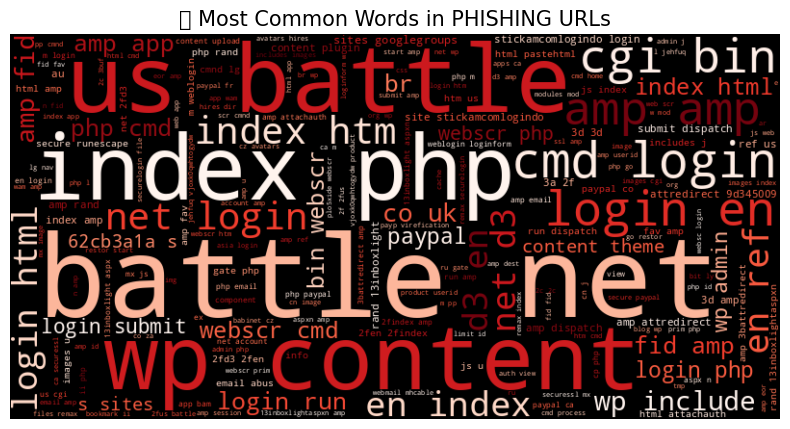

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


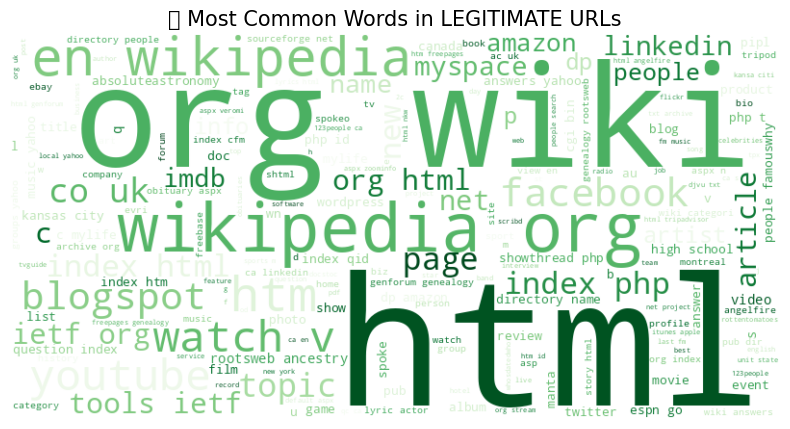

In [ ]:
# ☁️ Add this to a new cell to generate Word Clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Separate the Good and Bad sites
# Remember: 0 = Phishing (Bad), 1 = Legit (Good)
phishing_text = " ".join(df[df['Label'] == 0]['clean_url'])
legit_text = " ".join(df[df['Label'] == 1]['clean_url'])

# 2. Create the Word Cloud for Phishing Sites
wordcloud_phishing = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(phishing_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_phishing, interpolation='bilinear')
plt.axis('off')
plt.title("🚨 Most Common Words in PHISHING URLs", fontsize=15)
plt.show()

# 3. Create the Word Cloud for Legitimate Sites
wordcloud_legit = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(legit_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_legit, interpolation='bilinear')
plt.axis('off')
plt.title("✅ Most Common Words in LEGITIMATE URLs", fontsize=15)
plt.show()

In [ ]:
# 🛠️ Advanced Feature Engineering (REPLACES Step 5)
from urllib.parse import urlparse
import ipaddress
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer # Added this to prevent errors

# 1. Define functions to extract "Structural" features
def get_url_length(url):
    return len(url)

def count_dots(url):
    return url.count('.')

def has_ip_address(url):
    try:
        ipaddress.ip_address(url)
        return 1
    except:
        return 0

def count_slashes(url):
    return url.count('/')

# 2. Apply these functions to create new numerical columns
print("Extracting manual features...")
df['len_url'] = df['URL'].apply(get_url_length)
df['count_dots'] = df['URL'].apply(count_dots)
# Note: has_ip_address usually works better on the raw URL, not cleaned
df['has_ip'] = df['URL'].apply(has_ip_address)
df['count_slashes'] = df['URL'].apply(count_slashes)

# 3. Create the TF-IDF Features (The "Content" part)
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['clean_url'])

# 4. Create the Manual Features Matrix (The "Structural" part)
X_manual = df[['len_url', 'count_dots', 'has_ip', 'count_slashes']].values

# 5. Combine them!
X_combined = hstack([X_text, X_manual])

print(f"Old Shape (Text Only): {X_text.shape}")
print(f"New Shape (Text + Manual): {X_combined.shape}")
print("✅ Features combined successfully!")

# 6. Prepare for Split
X = X_combined
y = df['Label']

Extracting manual features...
Vectorizing text...
Old Shape (Text Only): (507196, 5000)
New Shape (Text + Manual): (507196, 5004)
✅ Features combined successfully!


In [ ]:
# 🔀 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

!pip install catboost # Keeping this here just in case of environment resets.
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=25),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Multinomial NB": MultinomialNB(),
}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
results = []
for name, model in models.items():
    print(f"🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Phishing", "Legit"]))
    print("-" * 60)


🔍 Training: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Accuracy: 0.9459
              precision    recall  f1-score   support

    Phishing       0.94      0.81      0.87     22860
       Legit       0.95      0.99      0.97     78580

    accuracy                           0.95    101440
   macro avg       0.94      0.90      0.92    101440
weighted avg       0.95      0.95      0.94    101440

------------------------------------------------------------
🔍 Training: Random Forest
✅ Accuracy: 0.8599
              precision    recall  f1-score   support

    Phishing       1.00      0.38      0.55     22860
       Legit       0.85      1.00      0.92     78580

    accuracy                           0.86    101440
   macro avg       0.92      0.69      0.73    101440
weighted avg       0.88      0.86      0.83    101440

------------------------------------------------------------
🔍 Training: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:00:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.9337
              precision    recall  f1-score   support

    Phishing       0.96      0.74      0.83     22860
       Legit       0.93      0.99      0.96     78580

    accuracy                           0.93    101440
   macro avg       0.94      0.86      0.90    101440
weighted avg       0.94      0.93      0.93    101440

------------------------------------------------------------
🔍 Training: Multinomial NB
✅ Accuracy: 0.9397
              precision    recall  f1-score   support

    Phishing       0.93      0.79      0.86     22860
       Legit       0.94      0.98      0.96     78580

    accuracy                           0.94    101440
   macro avg       0.94      0.89      0.91    101440
weighted avg       0.94      0.94      0.94    101440

------------------------------------------------------------


In [ ]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
results_df


,Model,Accuracy
0,Logistic Regression,0.945899
3,Multinomial NB,0.939688
2,XGBoost,0.933744
1,Random Forest,0.859858


In [ ]:
# 🧠 7. Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

✅ Accuracy: 0.9458990536277603

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87     22860
           1       0.95      0.99      0.97     78580

    accuracy                           0.95    101440
   macro avg       0.94      0.90      0.92    101440
weighted avg       0.95      0.95      0.94    101440



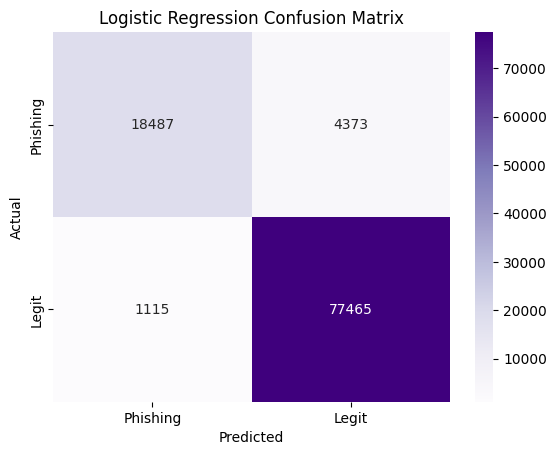

In [ ]:
# 📊 8. Evaluate Model
y_pred = lr_model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Phishing', 'Legit'], yticklabels=['Phishing', 'Legit'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [ ]:
sample_urls = [
    "http://login-verification-update.com",
    "https://www.paypal.com",
    "http://free-prize.ru",
    "https://www.apple.com",
    "http://password-reset-verify.org",
    "https://google.com",
    "http://bank-security-alert.co",
    "https://netflix-login-verification.com",
    "http://update-account-info.ru",
    "https://github.com"
]

# 🧹 Clean URLs
cleaned_urls = [clean_url(url) for url in sample_urls]

# 🔡 TF-IDF Vectorize
sample_features = vectorizer.transform(cleaned_urls)


In [ ]:
# Predict classes (0 = phishing, 1 = legit)

# 1. Extract manual features from sample_urls
sample_len_url = [get_url_length(url) for url in sample_urls]
sample_count_dots = [count_dots(url) for url in sample_urls]
sample_has_ip = [has_ip_address(url) for url in sample_urls]
sample_count_slashes = [count_slashes(url) for url in sample_urls]

# 2. Create a NumPy array for manual features
X_manual_sample = np.array([sample_len_url, sample_count_dots, sample_has_ip, sample_count_slashes]).T

# 3. Combine TF-IDF features with manual features
# sample_features is already a sparse matrix from vectorizer.transform
# X_manual_sample is a dense numpy array
sample_features_combined = hstack([sample_features, X_manual_sample])

predictions = lr_model.predict(sample_features_combined)

# Predict probabilities (optional)
probabilities = lr_model.predict_proba(sample_features_combined)[:, 1]  # Confidence for class 1 (Legit)

In [ ]:
for url, pred, prob in zip(sample_urls, predictions, probabilities):
    label = "✅ Legit" if pred == 1 else "⚠️ Phishing"
    print(f"{url} => {label} ({prob * 100:.2f}%)")


http://login-verification-update.com => ⚠️ Phishing (0.00%)
https://www.paypal.com => ⚠️ Phishing (0.02%)
http://free-prize.ru => ⚠️ Phishing (21.49%)
https://www.apple.com => ✅ Legit (79.80%)
http://password-reset-verify.org => ⚠️ Phishing (14.79%)
https://google.com => ✅ Legit (71.45%)
http://bank-security-alert.co => ⚠️ Phishing (14.42%)
https://netflix-login-verification.com => ⚠️ Phishing (0.94%)
http://update-account-info.ru => ⚠️ Phishing (0.06%)
https://github.com => ✅ Legit (79.40%)


In [ ]:
# 💾 10. Save Model & Vectorizer
joblib.dump(lr_model, "logistic_regression_phishing_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_lr.pkl")
print("Model and vectorizer saved.")


Model and vectorizer saved.


In [ ]:
import gradio as gr
import joblib
import re
import ipaddress
import numpy as np
from scipy.sparse import hstack

# 1. Load the saved model and vectorizer
try:
    model = joblib.load("logistic_regression_phishing_model.pkl")
    vectorizer = joblib.load("tfidf_vectorizer_lr.pkl")
    print("✅ Model and Vectorizer loaded successfully!")
except FileNotFoundError:
    print("❌ Error: .pkl files not found. Make sure you ran the Training step!")

# 2. Define ALL Helper Functions (Must match training code)
def clean_url(url):
    url = url.lower()
    url = re.sub(r'https?:\/\/', '', url)
    url = re.sub(r'www\d*\.', '', url)
    url = re.sub(r'[^a-z0-9\-\.\/]', ' ', url)
    url = re.sub(r'\s+', ' ', url)
    return url.strip()

def get_url_length(url):
    return len(url)

def count_dots(url):
    return url.count('.')

def has_ip_address(url):
    try:
        ipaddress.ip_address(url)
        return 1
    except:
        return 0

def count_slashes(url):
    return url.count('/')

# 3. Define the Prediction Function
def predict_phishing(url):
    # --- Part A: Text Features ---
    cleaned_url = clean_url(url)
    text_features = vectorizer.transform([cleaned_url]) # Shape: (1, 5000)

    # --- Part B: Manual Features ---
    # We must extract the exact same features we trained on
    f_length = get_url_length(url)
    f_dots = count_dots(url)
    f_ip = has_ip_address(url)
    f_slashes = count_slashes(url)

    # Create a numpy array for these 4 numbers (Shape: 1, 4)
    manual_features = np.array([[f_length, f_dots, f_ip, f_slashes]])

    # --- Part C: Combine & Predict ---
    # Stack them side-by-side to get Shape: (1, 5004)
    combined_features = hstack([text_features, manual_features])

    probabilities = model.predict_proba(combined_features)[0]

    return {
        "⚠️ Phishing": float(probabilities[0]),
        "✅ Legitimate": float(probabilities[1])
    }

# 4. Create Interface
interface = gr.Interface(
    fn=predict_phishing,
    inputs=gr.Textbox(label="Enter URL", placeholder="Type or paste a URL here..."),
    outputs=gr.Label(num_top_classes=2, label="Result"),
    title="🛡️ Advanced Phishing Detector",
    description="This hybrid model analyzes both the **text content** and the **structure** (dots, length, etc.) of the URL.",
    theme="default"
)

if __name__ == "__main__":
    interface.launch(share=True)

✅ Model and Vectorizer loaded successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b453144996a7460513.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
